In [32]:
import pandas as pd

# 1、数据预处理
df = pd.read_csv("/Users/datou/PycharmProjects/model/HengyangSta/HY_data/衡阳站降雨径流.csv", parse_dates=["Date"])
df_copy = df
df.reset_index(drop=True)
df = df.set_index('Date')
df

,Q,P
Date,,
1985-01-01,385,1.218001
1985-01-02,353,1.418061
1985-01-03,350,1.519668
1985-01-04,375,1.140323
1985-01-05,360,2.144906
...,...,...
2001-12-27,766,0.000000
2001-12-28,653,0.000000
2001-12-29,536,0.000000


In [33]:
n_past=15

In [34]:
"""
划分数据
"""
test_split = round(len(df) * 0.30)
df_for_training = df[:-test_split]
df_for_testing = df[-(test_split+n_past):]
df_for_testing

,Q,P
Date,,
1996-11-10,393,0.631212
1996-11-11,384,2.396213
1996-11-12,456,3.359430
1996-11-13,471,1.110440
1996-11-14,395,0.492048
...,...,...
2001-12-27,766,0.000000
2001-12-28,653,0.000000
2001-12-29,536,0.000000


In [35]:
from sklearn.preprocessing import StandardScaler
import numpy as np

"""
数据归一化
"""
scaler = StandardScaler().fit(df_for_training)
df_for_training = scaler.transform(df_for_training)
df_for_testing = scaler.transform(df_for_testing)


In [36]:
timesteps = 16
train_data = np.array(
    [[j for j in df_for_training[i:i + timesteps]] for i in range(0, len(df_for_training) - timesteps + 1)])[:, :, 0]
train_data

array([[-0.68592696, -0.70968963, -0.71191738, ..., -0.57453946,
        -0.58419304, -0.61612412],
       [-0.70968963, -0.71191738, -0.69335279, ..., -0.58419304,
        -0.61612412, -0.56934137],
       [-0.71191738, -0.69335279, -0.70449155, ..., -0.61612412,
        -0.56934137, -0.55820262],
       ...,
       [-0.7289968 , -0.70449155, -0.72231355, ..., -0.69409538,
        -0.7379078 , -0.74904655],
       [-0.70449155, -0.72231355, -0.67998629, ..., -0.7379078 ,
        -0.74904655, -0.72231355],
       [-0.72231355, -0.67998629, -0.68666954, ..., -0.74904655,
        -0.72231355, -0.69112504]])

In [37]:
# 单变量嵌套表格
test_data=np.array([[j for j in df_for_testing[i:i+timesteps]] for i in range(0,len(df_for_testing)-timesteps+1)])[:,:,0]
test_data.shape

(1863, 16)

In [38]:
trainX, trainY = train_data[:,:timesteps-1],train_data[:,[timesteps-1]]
testX, testY = test_data[:,:timesteps-1],test_data[:,[timesteps-1]]
trainX.shape

(4331, 15)

In [39]:
testY.shape

(1863, 1)

In [40]:
"""
构建SVR回归模型
"""
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# 构建模型
# 使用网格搜索寻找最优参数
param_grid = {"kernel": ["rbf"], 'C': [10, 100, 1000], 'gamma': [0.01,0.05,0.1,1]}
grid_svr = GridSearchCV(SVR(), param_grid, cv=5)
grid_svr.fit(trainX, trainY)
my_model = grid_svr.best_estimator_
# 预测
my_model.fit(trainX, trainY)
y_pred = my_model.predict(testX)
y_pred

/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/datou/anaconda3/envs/normal310/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A colu

array([-0.63609391, -0.63940089, -0.65451747, ..., -0.50990671,
       -0.5760844 , -0.58924827])

In [41]:
grid_svr.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [42]:
"""
进行预测：训练集
"""
train_predict=my_model.predict(trainX)

In [43]:
# 对数据进行逆缩放
y_pred_copy = np.repeat(y_pred, 2, axis=-1)
pred = scaler.inverse_transform(np.reshape(y_pred_copy, (len(y_pred), 2)))[:, 0]
pred = pd.DataFrame(pred)
pred.columns = ["Qsim"]
pred

,Qsim
0,452.107690
1,447.654346
2,427.297602
3,300.937054
4,401.121845
...,...
1858,796.338839
1859,816.775477
1860,622.037698
1861,532.919503


In [44]:
# 同样步骤进行逆变换
original_copies_array = np.repeat(testY, 2, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 2)))[:, 0]
original.shape

(1863,)

In [45]:
# 对测试集输出数据进行逆变换
prediction_copies_array = np.repeat(train_predict, 2, axis=-1)
train_pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(train_predict), 2)))[:, 0]
train_pred.shape

(4331,)

In [46]:
# 对测试数据Y进行逆变换
train_original_copies_array = np.repeat(trainY, 2, axis=-1)
train_original = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(trainY), 2)))[:, 0]
train_original.shape

(4331,)

In [47]:
train_pred=pd.DataFrame(train_pred)
train_pred.columns=['Qsim']
train_pred

,Qsim
0,566.903486
1,503.363165
2,633.332359
3,597.860601
4,477.763243
...,...
4326,405.022422
4327,437.552414
4328,339.520811
4329,362.785901


In [48]:
original=pd.DataFrame(original)
original.columns=['Qobs']
original

,Qobs
0,391.0
1,383.0
2,292.0
3,316.0
4,309.0
...,...
1858,766.0
1859,653.0
1860,536.0
1861,483.0


In [49]:
train_original=pd.DataFrame(train_original)
train_original.columns=['Qobs']
train_original

,Qobs
0,479.0
1,542.0
2,557.0
3,476.0
4,464.0
...,...
4326,374.0
4327,315.0
4328,300.0
4329,336.0


In [50]:
test_df=df_copy[-test_split:]
test_df

,Date,Q,P
4346,1996-11-25,391,0.067122
4347,1996-11-26,383,0.429786
4348,1996-11-27,292,0.194327
4349,1996-11-28,316,1.199373
4350,1996-11-29,309,0.971816
...,...,...,...
6204,2001-12-27,766,0.000000
6205,2001-12-28,653,0.000000
6206,2001-12-29,536,0.000000
6207,2001-12-30,483,0.000000


In [51]:
train_df=df_copy[n_past:-test_split]
train_df

,Date,Q,P
15,1985-01-16,479,2.189848
16,1985-01-17,542,2.253480
17,1985-01-18,557,0.019066
18,1985-01-19,476,0.030029
19,1985-01-20,464,0.040337
...,...,...,...
4341,1996-11-20,374,0.001667
4342,1996-11-21,315,0.035148
4343,1996-11-22,300,0.069435
4344,1996-11-23,336,0.108885


In [52]:
test_df=test_df.reset_index(drop=True)
test_df=test_df['Date']
test_df

0      1996-11-25
1      1996-11-26
2      1996-11-27
3      1996-11-28
4      1996-11-29
          ...    
1858   2001-12-27
1859   2001-12-28
1860   2001-12-29
1861   2001-12-30
1862   2001-12-31
Name: Date, Length: 1863, dtype: datetime64[ns]

In [53]:
train_df=train_df.reset_index(drop=True)
train_df=train_df['Date']
train_df

0      1985-01-16
1      1985-01-17
2      1985-01-18
3      1985-01-19
4      1985-01-20
          ...    
4326   1996-11-20
4327   1996-11-21
4328   1996-11-22
4329   1996-11-23
4330   1996-11-24
Name: Date, Length: 4331, dtype: datetime64[ns]

In [54]:
test_df_full=pd.concat([test_df,original,pred],axis=1)
test_df_full=test_df_full.reset_index(drop=True)
test_df_full=test_df_full.set_index('Date')
test_df_full.to_csv('/Users/datou/PycharmProjects/model/HengyangSta/HY_data/HY_TestSVR.csv')
test_df_full

,Qobs,Qsim
Date,,
1996-11-25,391.0,452.107690
1996-11-26,383.0,447.654346
1996-11-27,292.0,427.297602
1996-11-28,316.0,300.937054
1996-11-29,309.0,401.121845
...,...,...
2001-12-27,766.0,796.338839
2001-12-28,653.0,816.775477
2001-12-29,536.0,622.037698


In [55]:
train_df_full=pd.concat([train_df,train_original,train_pred],axis=1)
train_df_full=train_df_full.reset_index(drop=True)
train_df_full=train_df_full.set_index('Date')
train_df_full.to_csv('/Users/datou/PycharmProjects/model/HengyangSta/HY_data/HY_TrainSVR.csv')
train_df_full

,Qobs,Qsim
Date,,
1985-01-16,479.0,566.903486
1985-01-17,542.0,503.363165
1985-01-18,557.0,633.332359
1985-01-19,476.0,597.860601
1985-01-20,464.0,477.763243
...,...,...
1996-11-20,374.0,405.022422
1996-11-21,315.0,437.552414
1996-11-22,300.0,339.520811


In [56]:
from tool import evalIndicator
# 计算nash效率系数
evalIndicator.eval(test_df_full['Qsim'], test_df_full['Qobs'])

MAE:232.2686685747825
RMSE:497.89704533461145
R2:0.8860725373052871
NSE:0.8860725373052872
RE:-2.2115365069826285
Qmaxe:0.04252059092093113
Qmine:0.8057195695695493


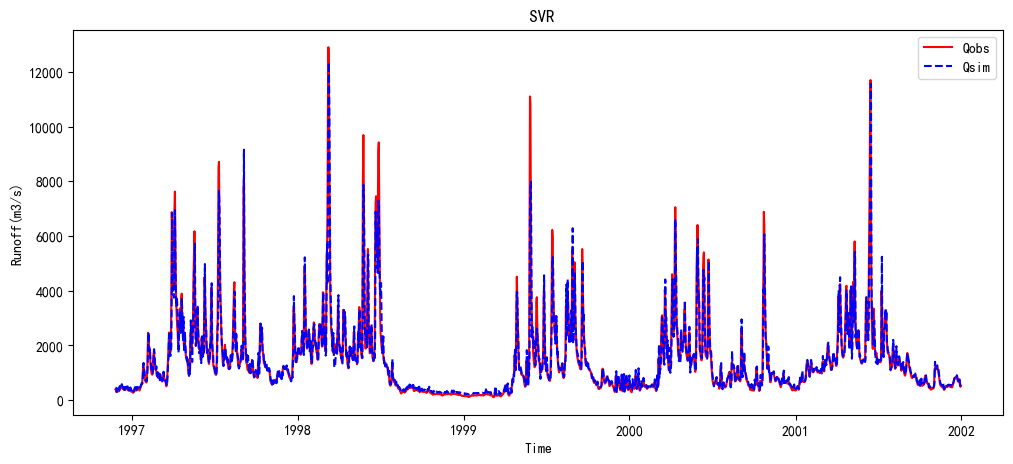

In [57]:
# 比较预测值和原始值，进行绘图展示
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(test_df_full['Qobs'], color='red', label='Qobs')
plt.plot(test_df_full['Qsim'], color='blue', label='Qsim',linestyle="--")
plt.title(' SVR')
plt.xlabel('Time')
plt.ylabel('Runoff(m3/s)')
plt.legend()
plt.show()

MAE:183.4159196048388
RMSE:413.12621046162707
R2:0.9060825467290825
NSE:0.9060825467290827
RE:-1.6236112700270717
Qmaxe:0.05774863981727215
Qmine:0.5246909718628049


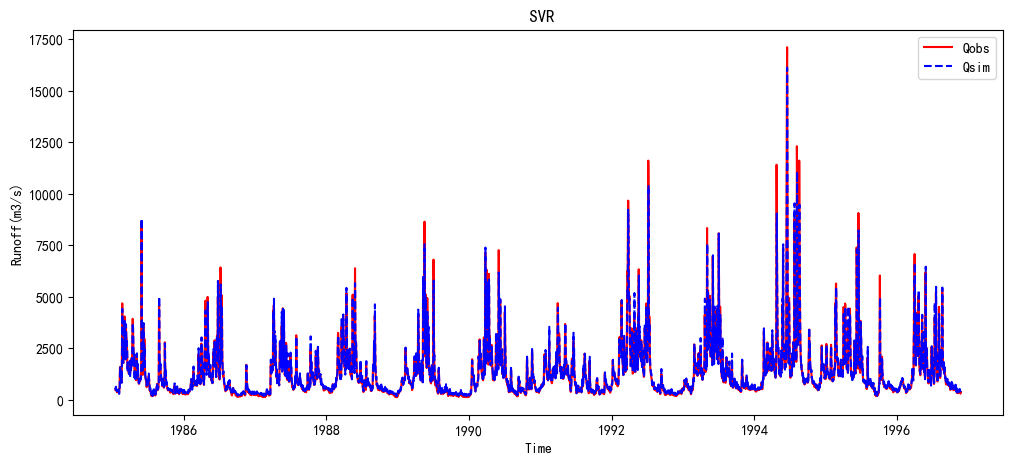

In [58]:
# 计算nash效率系数
evalIndicator.eval(train_df_full['Qsim'], train_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(12,5))
plt.plot(train_df_full['Qobs'], color='red', label='Qobs')
plt.plot(train_df_full['Qsim'], color='blue', label='Qsim',linestyle="--")
plt.title(' SVR')
plt.xlabel('Time')
plt.ylabel('Runoff(m3/s)')
plt.legend()
plt.show()